In [1]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
from torch import nn
from torch import optim
import progressbar
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import transforms
from torch import nn
from torch import optim
import progressbar
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
import torch
from torch.utils.data import DataLoader, Dataset
from CNN_tools import *
from CNN_UNET import *
from pytorch_lightning.callbacks import ModelCheckpoint
from DATALOADER import Pdf_Image_DataSet
from variables import *
import progressbar
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import transforms
from torch import nn
from torch import optim
import progressbar
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
import torch
from torch.utils.data import DataLoader, Dataset

In [2]:
### LOAD ALL DATA ####

(image_test,pdf_test,pdf_filter_test) = load_data_test_all()
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)
(image_test,pdf_test,pdf_filter_test) = (image_test[:-28],pdf_test[:-28],pdf_filter_test[:-28])
print((image_test.shape[0])/32)
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)

Loading simu2 images ...
Done
Loading pdf simu2 ...
Pdf simu2 loaded
Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded
214.0


In [23]:
np.nanmean(np.std(prediction_10,axis=0),axis=(1,2)).shape

(32,)

In [19]:
np.nanmean(np.std(np.array(image_test[:10,0,:,:]),axis=(0)),axis=0)

array([0.14562444, 0.14635615, 0.14839017, 0.1397972 , 0.13042377,
       0.12785934, 0.1298207 , 0.1314035 , 0.12493834, 0.11849029,
       0.11505617, 0.11222597, 0.11240077, 0.11141807, 0.11293197,
       0.11282036, 0.11624616, 0.11738039, 0.12082869, 0.12194268,
       0.12117192, 0.1206385 , 0.12025479, 0.12083921, 0.12114654,
       0.12352133, 0.12670651, 0.12899792, 0.13187526, 0.13119903,
       0.12873366, 0.12676156, 0.1235062 , 0.12388418, 0.11718908,
       0.11220183, 0.11126731, 0.11352021, 0.10948311, 0.1064467 ,
       0.10301094, 0.10277936, 0.09637445, 0.09179173, 0.09171293,
       0.09385394, 0.09590047, 0.09243155, 0.09278923, 0.09282728,
       0.09429868, 0.09416167, 0.09188479, 0.09206846, 0.09452721,
       0.09436325, 0.09320441, 0.09340443, 0.09230969, 0.09090152,
       0.09228475, 0.09852301, 0.1025787 , 0.10668356, 0.1121634 ,
       0.11600944, 0.12223523, 0.12428731, 0.12457292, 0.12448696,
       0.12880947, 0.13182074, 0.13149263, 0.13425675, 0.13425

In [24]:
device='cuda'

super_model = np.zeros((pdf_test.shape[0],100,100))
super_model_norm = np.zeros((pdf_test.shape[0],100,100))
prediction_10 = np.zeros((10,batch_size,100,100))
#prediction_10_last = np.zeros((10,20,100,100))

# Pour STD 
#pdf_10 = np.zeros((10,image_test.shape[0],100,100))
STD = np.zeros((image_test.shape[0]))

i = 0

kernel_size=5
padding=2
bias=False
p_dropout=0
nlayer0=64
nb_inputs = 76 #28

dirSAVE = './Saved_model'

with torch.no_grad():
    for batch, (X, y_filter, y) in enumerate(test_loader):
        # TRAIN MODEL
        X, y_filter, y = X.to(device), y_filter.to(device), y.to(device)
        
        for j in range(0,10):
        
            autoencoder = CNN_UNET_generic.load_from_checkpoint(dirSAVE+'/supermodel/CNN_UNET_k5_p2_bFalse_d0_nl64_ni_76_{0}.ckpt'.format(j),kernel_size=kernel_size,padding=padding,bias=bias,p_dropout=p_dropout,nlayer0=nlayer0,nb_inputs=nb_inputs).to(device)
            filename_chkpt = 'CNN_UNET_k{0}_p{1}_b{2}_d{3}_nl{4}_ni_{5}_{6}'.format(kernel_size,padding,bias,p_dropout,nlayer0,nb_inputs,j)
            prediction_test = autoencoder(X,y_filter,y)[:,-1,:,:]
            prediction_10[j,:,:,:] = prediction_test.cpu().detach().numpy()
            

            
            ### Calcul STD des 10 predictions 
            #pdf_10[:,i*32:i*32+32,:,:] = prediction_10
            
            
        prediction_10 = np.sort(prediction_10,axis=0)
        super_model[batch_size*i:batch_size*i+batch_size,:,:] = np.median(prediction_10,axis=0)
        STD[batch_size*i:batch_size*i+batch_size] = np.nanmean(np.std(prediction_10,axis=0),axis=(1,2))
            
        #print(i)
        i = i+1

for i in range(pdf_test.shape[0]):
    super_model_norm[i,:,:] = super_model[i,:,:]/np.sum(super_model[i,:,:])

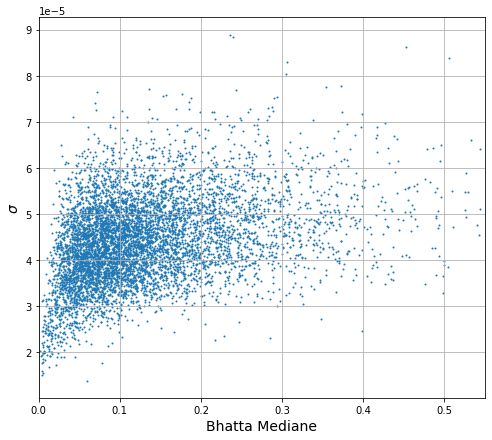

In [28]:
#CHECK
%matplotlib inline

list_bhatta = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_norm[i,:,:], pdf_filter_test[i,-1,:,:])))))

plt.figure(figsize=(8,7))
plt.scatter(list_bhatta,STD,s=1)
plt.xlabel('Bhatta Mediane',size='14')
plt.ylabel(r'$\sigma$',size='14')
plt.xlim(0,0.55)
#plt.ylim(0,0.125)
plt.grid()

In [29]:
#SAVE

#creating the file
nc = nc4.Dataset('STD_article_4L.nc','w')

nc.createDimension('nbsample', pdf_filter_test.shape[0])
nc.createVariable('std', 'f8', ('nbsample'))
nc.variables['std'][:] =  STD
nc.close()



# SURFACE DATA

In [30]:
### LOAD ALL DATA ####

(image_test,pdf_test,pdf_filter_test) = load_data_test_surface_all()
(image_test,pdf_test,pdf_filter_test) = (image_test[:-28],pdf_test[:-28],pdf_filter_test[:-28])
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)
test_set = Pdf_Image_DataSet(image_test,pdf_test,pdf_filter_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = False, drop_last=False)

Loading simu2 surface data ...
Done
Loading pdf simu2 ...
Pdf simu2 loaded
Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded


In [31]:
# Save direction and type of cn
device='cuda'

super_model = np.zeros((pdf_test.shape[0],100,100))
super_model_norm = np.zeros((pdf_test.shape[0],100,100))
prediction_10 = np.zeros((10,batch_size,100,100))
#prediction_10_last = np.zeros((10,20,100,100))
i = 0

kernel_size=5
padding=2
bias=False
p_dropout=0
nlayer0=64
nb_inputs = 28 #28
STD = np.zeros((image_test.shape[0]))

dirSAVE = './Saved_model'

pdf_10 = np.zeros((10,image_test.shape[0],100,100))


with torch.no_grad():
    for batch, (X, y_filter, y) in enumerate(test_loader):
        # TRAIN MODEL
        X, y_filter, y = X.to(device), y_filter.to(device), y.to(device)
        
        for j in range(0,10):
        
            autoencoder = CNN_UNET_generic.load_from_checkpoint(dirSAVE+'/supermodel/CNN_UNET_k5_p2_bFalse_d0_nl64_ni_28_{0}.ckpt'.format(j),kernel_size=kernel_size,padding=padding,bias=bias,p_dropout=p_dropout,nlayer0=nlayer0,nb_inputs=nb_inputs).to(device)
            filename_chkpt = 'CNN_UNET_k{0}_p{1}_b{2}_d{3}_nl{4}_ni_{5}_{6}'.format(kernel_size,padding,bias,p_dropout,nlayer0,nb_inputs,j)
            prediction_test = autoencoder(X,y_filter,y)[:,-1,:,:]
            prediction_10[j,:,:,:] = prediction_test.cpu().detach().numpy()
        
        pdf_10[:,i*32:i*32+32,:,:] = prediction_10
        prediction_10 = np.sort(prediction_10,axis=0)
        super_model[batch_size*i:batch_size*i+batch_size,:,:] = np.median(prediction_10,axis=0)
        STD[batch_size*i:batch_size*i+batch_size] = np.nanmean(np.std(prediction_10,axis=0),axis=(1,2))
             
        #print(i)
        i = i+1

for i in range(pdf_test.shape[0]):
    super_model_norm[i,:,:] = super_model[i,:,:]/np.sum(super_model[i,:,:])

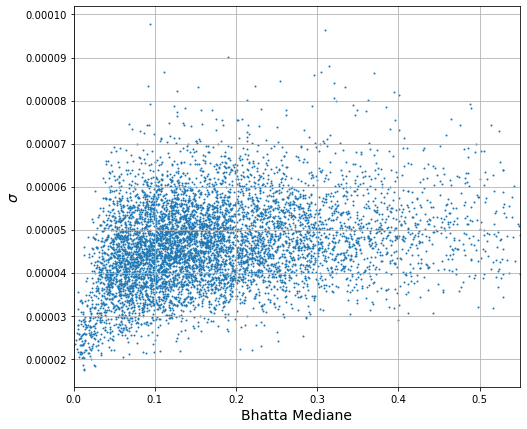

In [32]:
#CHECK
%matplotlib inline

list_bhatta = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_norm[i,:,:], pdf_filter_test[i,-1,:,:])))))

plt.figure(figsize=(8,7))
plt.scatter(list_bhatta,STD,s=1)
plt.xlabel('Bhatta Mediane',size='14')
plt.ylabel(r'$\sigma$',size='14')
plt.xlim(0,0.55)
#plt.ylim(0,0.125)
plt.grid()

In [33]:
#SAVE

#creating the file
nc = nc4.Dataset('STD_article_surf.nc','w')

nc.createDimension('nbsample', pdf_filter_test.shape[0])
nc.createVariable('std', 'f8', ('nbsample'))
nc.variables['std'][:] =  STD
nc.close()
